<a href="https://colab.research.google.com/github/vblagoje/notebooks/blob/main/haystack2x-demos/haystack_rag_services_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This notebook demonstrates an innovative use of the Qdrant vector database within a Haystack 2 OpenAPI service-based Retriever-Augmented Generation (RAG) application.

Starting with a user prompt, we fetch the appropriate OpenAPI (OAS)specification from Qdrant, as well as the matching system message. These retrieved text documents are then injected into the Haystack pipeline, facilitating the dynamic invocation of specific OAS services. By merging any OAS service with Large Language Models (LLMs), this cutting-edge method opens a new phase in RAG systems, enabling the generation of deeply contextual responses from structured OAS data services.

**Note**: Detailed description of the entire process can be found in step 5. Please follow along.

## 1. Setup
This notebook demos Haystack 2.x service based RAG, using two openapi services: GitHub's compare_branches and SerperDev search API.

Let's install necessary libraries and import key modules to build the foundation for the subsequent steps.

In [ ]:
!pip install --no-deps sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 1.6 MB/s eta 0:00:00


In [ ]:
!pip install "grpcio-tools==1.42" jsonref openapi3 qdrant-haystack git+https://github.com/deepset-ai/haystack.git

In [ ]:
import getpass
import os
import json
import jsonref
import requests
from typing import List, Dict, Any
from haystack_integrations.document_stores.qdrant import QdrantDocumentStore
from haystack_integrations.components.retrievers.qdrant import QdrantEmbeddingRetriever

from haystack import Pipeline, Document
from haystack.components.generators.utils import print_streaming_chunk
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.converters import OpenAPIServiceToFunctions, OutputAdapter
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.connectors import OpenAPIServiceConnector
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.others import Multiplexer
from haystack.dataclasses import ChatMessage, ByteStream

### 1.1 Let's collect the API keys for LLM provider

In [ ]:
llm_providers = {"fireworks": {"api_base_url": "https://api.fireworks.ai/inference/v1",
                               "text_model": "accounts/fireworks/models/mixtral-8x7b-instruct",
                               "fc_model": "accounts/fireworks/models/firefunction-v1"},
                 "openai": {"api_base_url": "https://api.openai.com/v1",
                            "text_model": "gpt-4-turbo-preview",
                            "fc_model": "gpt-3.5-turbo"}
                 }

# change this value to another provider defined above - if needed
selected_provider = "fireworks"
llm_api_key = getpass.getpass(f"Enter {selected_provider} api key:")


### 1.2 And OpenAPI services we'll use:

In [ ]:
serper_token = getpass.getpass("Enter serperdev api key:")
github_token = getpass.getpass("Enter your github token:")
tinurl_token = getpass.getpass("Enter your tinyurl token:")

## 2. Setup QdrantDocumentStore

QdrantDocumentStore is one of many vector DB integrations we offer via Haystack Core Integrations [project](https://github.com/deepset-ai/haystack-core-integrations/)

In [ ]:
# Note: for the demo we are using Qdrant in local on-disk mode.
# For production use cases, a Docker container should be preferred.
# See https://qdrant.tech/documentation/ for more details

document_store = QdrantDocumentStore(
    path="./qdrant_1",
    index="Document",
    embedding_dim=768,
    recreate_index=True
  )

### 2.1 Add some helper functions we'll use in both indexing and retrieval pipelines

In [ ]:
def prepare_fc(openai_functions_schema: Dict[str, Any]) -> Dict[str, Any]:
    return {
        "tools": [{
            "type": "function",
            "function": openai_functions_schema
        }],
        "tool_choice": {
            "type": "function",
            "function": {"name": openai_functions_schema["name"]}
        }
    }

def create_docs(functions, specs, system_messages, service_credentials):
  docs = []
  for function, spec, system_message, service_credential in zip(functions, specs, system_messages, service_credentials):
    d = Document(content=json.dumps(function),
                 meta={"spec": json.dumps(spec),
                       "system_message": system_message,
                       "service_credential": service_credential}) #it's just a demo - relax
    docs.append(d)
  return docs

## 3. Index OpenAPI specs

Each indexed service Document contains the following descriptors:

* OpenAI function calling JSON
* OpenAPI specification
* System message for the service
* Service credentials

In [ ]:
embedding_model = "sentence-transformers/all-mpnet-base-v2"

# Note: if you play with the notebook and add more OAS services you are likely to get better service inference
# results with jina-embeddings-v2-small-en embedding model. jina-embeddings-v2-small-en is an English, monolingual
# embedding model supporting 8192 sequence length which should be enough for our Document describing OpenAI
# functions, OAS spec, and sytem message stored.
#
# Or if you simply want to try out jina-embeddings-v2-small-en uncomment the following lines of code

# embedding_model = "jina-embeddings-v2-small-en"
# os.environ['HF_API_TOKEN'] = "<your HuggingFace token here>"

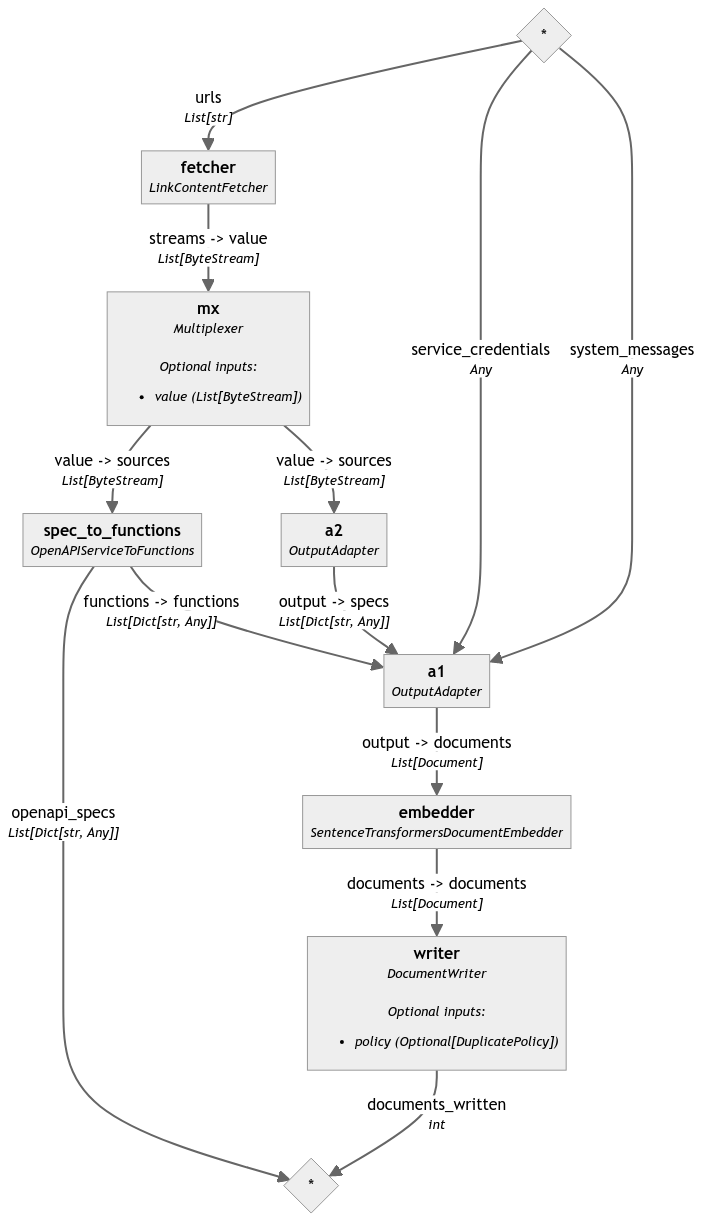

In [ ]:
indexing_pipeline = Pipeline()
indexing_pipeline.add_component("fetcher", LinkContentFetcher())
indexing_pipeline.add_component("mx", Multiplexer(List[ByteStream]))
indexing_pipeline.add_component("spec_to_functions", OpenAPIServiceToFunctions())
indexing_pipeline.add_component("embedder", SentenceTransformersDocumentEmbedder(model=embedding_model,
                                                                                 meta_fields_to_embed=["spec", "system_message", "service_credential"],
                                                                                 trust_remote_code=True))
indexing_pipeline.add_component("writer", DocumentWriter(document_store=document_store))
indexing_pipeline.add_component("a1", OutputAdapter("{{functions | create_docs(specs, system_messages, service_credentials)}}",
                                                     List[Document],
                                                      {"create_docs": create_docs}))

indexing_pipeline.add_component("a2", OutputAdapter("{{sources | json_objects}}",
                                                     List[Dict[str, Any]],
                                                      {"json_objects": lambda sources: [json.loads(s.to_string()) for s in sources]}))

indexing_pipeline.connect("fetcher.streams", "mx")
indexing_pipeline.connect("mx", "spec_to_functions.sources")
indexing_pipeline.connect("mx", "a2.sources")
indexing_pipeline.connect("a2", "a1.specs")
indexing_pipeline.connect("spec_to_functions.functions", "a1")
indexing_pipeline.connect("a1.output", "embedder.documents")
indexing_pipeline.connect("embedder", "writer")

### 3.1 We'll use three OAS services: GitHub, SerperDev, TinyURL



*   GitHub - compare branches operation
*   SerperDev - a search engine bridge
*   TinyURL - URL shortener  



In [ ]:
services = {"open_api_specs": ["https://bit.ly/github_compare","https://bit.ly/serper_dev_spec", "https://bit.ly/tinyurl_spec"],
            "system_messages":["https://bit.ly/pr_auto_system", "https://bit.ly/serper_system","https://bit.ly/tinyurl_system_prompt"]}

In [ ]:
result = indexing_pipeline.run(data={"fetcher": {"urls": services["open_api_specs"]},
                                     "a1":{"service_credentials": [github_token, serper_token, tinurl_token],
                                           "system_messages": [requests.get(url).text for url in services["system_messages"]]
                                           }
                                     })
print(f"\nWrote {result['writer']['documents_written']} documents")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100it [00:00, 2856.20it/s]           


Wrote 3 documents


## 4. Build the retrieval/LLM generation pipeline

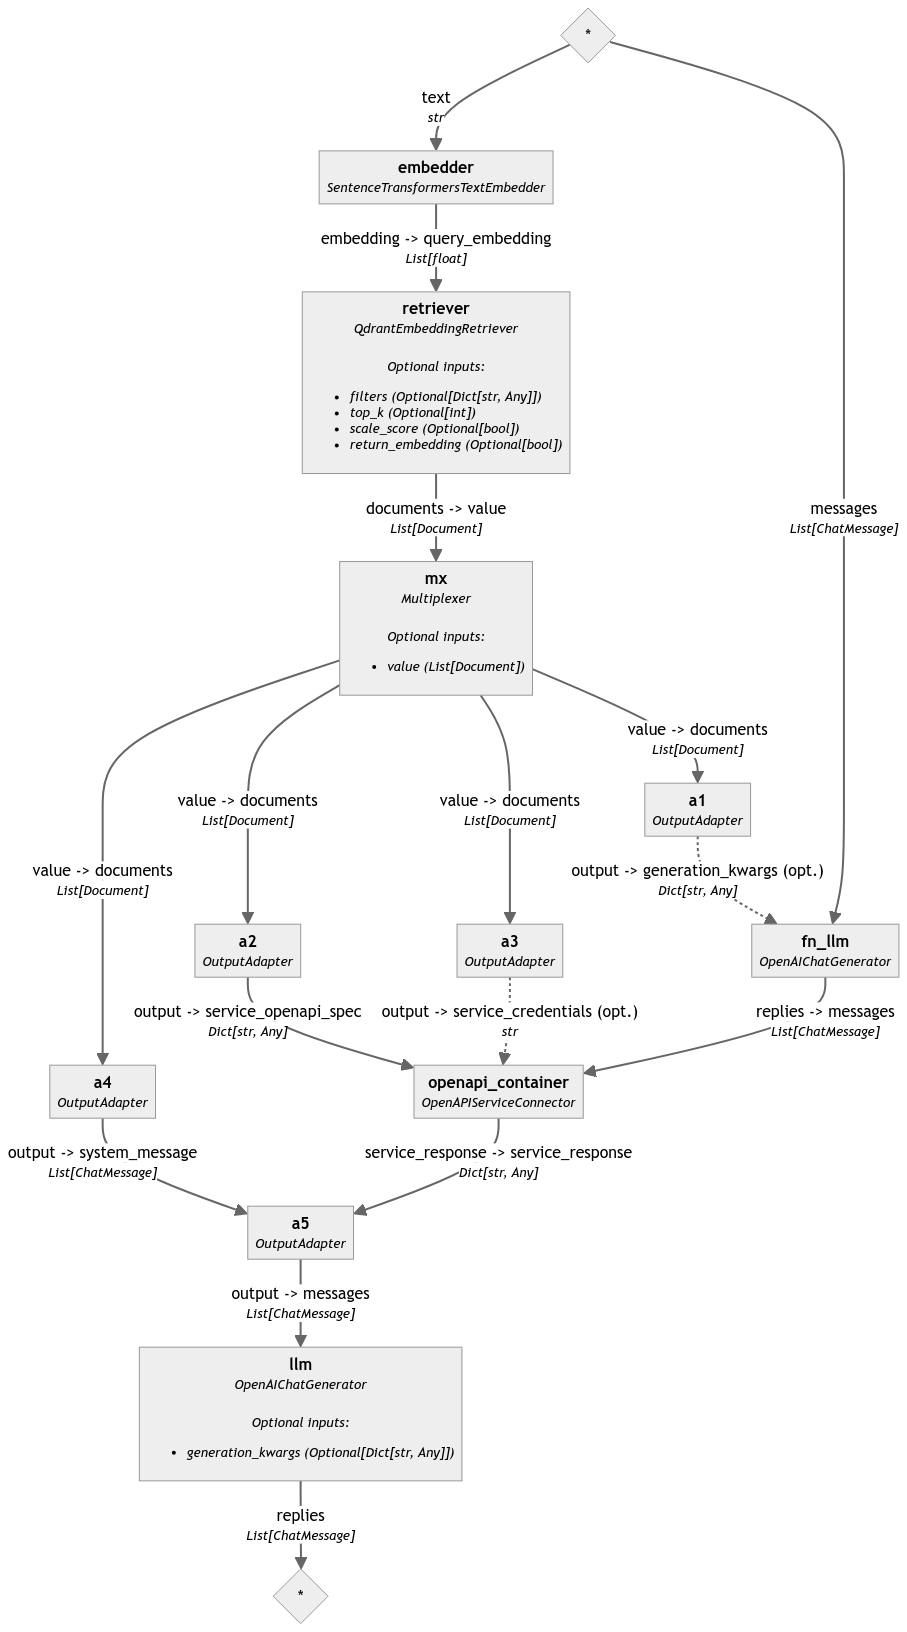

In [ ]:
from haystack.utils import Secret

pipe = Pipeline()
pipe.add_component("embedder", SentenceTransformersTextEmbedder(model=embedding_model, trust_remote_code=True))
pipe.add_component("retriever", QdrantEmbeddingRetriever(document_store=document_store))
pipe.add_component("mx", Multiplexer(List[Document]))
pipe.add_component("a1", OutputAdapter("{{documents[0].content | tojson | prepare_fc}}", Dict[str, Any], {"prepare_fc": prepare_fc, "tojson": lambda s: json.loads(s)}))
pipe.add_component("a2", OutputAdapter("{{documents[0].meta['spec'] | tojson}}", Dict[str, Any], {"tojson": lambda s: jsonref.replace_refs(json.loads(s))}))
pipe.add_component("a3", OutputAdapter("{{documents[0].meta['service_credential']}}", str))
pipe.add_component("a4", OutputAdapter("{{documents[0].meta['system_message'] | cm}}", List[ChatMessage], {"cm": lambda s: [ChatMessage.from_system(s)]}))
pipe.add_component("a5", OutputAdapter("{{system_message + service_response}}", List[ChatMessage], {"cm": lambda s: [ChatMessage.from_system(s)]}))
pipe.add_component("fn_llm", OpenAIChatGenerator(api_key=Secret.from_token(llm_api_key),
                                                 model=llm_providers[selected_provider]["fc_model"],
                                                 api_base_url=llm_providers[selected_provider]["api_base_url"]))
pipe.add_component("openapi_container", OpenAPIServiceConnector())
pipe.add_component("llm", OpenAIChatGenerator(api_key=Secret.from_token(llm_api_key),
                                              streaming_callback=print_streaming_chunk,
                                              api_base_url=llm_providers[selected_provider]["api_base_url"],
                                              generation_kwargs={"max_tokens": 1024},
                                              model=llm_providers[selected_provider]["text_model"],
                                              ))

pipe.connect("embedder", "retriever")
pipe.connect("retriever.documents", "mx")
pipe.connect("mx", "a1.documents")
pipe.connect("mx", "a2.documents")
pipe.connect("mx", "a3.documents")
pipe.connect("mx", "a4.documents")
pipe.connect("a1", "fn_llm.generation_kwargs")
pipe.connect("a2", "openapi_container.service_openapi_spec")
pipe.connect("a3", "openapi_container.service_credentials")
pipe.connect("a4", "a5.system_message")
pipe.connect("a5", "llm.messages")
pipe.connect("openapi_container.service_response", "a5.service_response")
pipe.connect("fn_llm.replies", "openapi_container.messages")

## 5. Retrieval, service invocation and LLM generation

Here is where everything gets interesting! Based on the prompt below, we'll retrieve the top_k=1 document from QdrantDocumentStore. That'll be the relevant service Document. We'll then proceed to use service descriptors from the retrieved Document to initiate:

* Step 1: Function calling to resolve the parameters for service invocation.

<img src="https://raw.githubusercontent.com/vblagoje/various/main/OAS-1.1.png" width="600" alt="Step 1">

* Step 2: We'll invoke the OpenAPI-compliant service with those parameters.
<img src="https://raw.githubusercontent.com/vblagoje/various/main/OAS-2.png" width="600" alt="Step 1">

* Step 3: The response from the service will be joined with the system prompt for that service.
<img src="https://raw.githubusercontent.com/vblagoje/various/main/OAS-3.png" width="600" alt="Step 1">

* Step 4: The final LLM response will be generated.


This process involves straightforward intent recognition that utilizes vector similarity to accurately identify and retrieve the appropriate service Document. Theoretically, it's possible to have dozens of services indexed within the QdrantDocumentStore. Once we retrieve the right service Documents, we will rely on the Haystack pipeline to perform the magic and observe the response generated by the LLM.

In [ ]:
# To select a specific prompt for the pipeline simply uncomment the desired `user_prompt` line
# by removing the `#` at the beginning of the line, and comment out the other prompts by
# adding a `#`. Ensure only one prompt is active at a time before running the pipeline.

#user_prompt = "Search Google and answer: why did Elon Musk sue OpenAI?"
#user_prompt = "Compare Github branches main and test/benchmarks2.0, in project deepset-ai, repo haystack"
user_prompt = "Using TinyURL create a shortened URL from this long URL https://haystack.deepset.ai/blog/haystack-2-release"

result = pipe.run(data={"fn_llm": {"messages":[ChatMessage.from_user(user_prompt)]}, "embedder": {"text": user_prompt}})


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

https://tinyurl.com/ya7hv2h8

(This is just the value of the "tiny\_url" key from the provided JSON data.)

## Thank you, questions?

<a href="www.qr-code-generator.com/" border="0" style="cursor:default" rel="nofollow"><img src="https://chart.googleapis.com/chart?cht=qr&chl=https%3A%2F%2Fgithub.com%2Fvblagoje%2Fnotebooks%2Fblob%2Fmain%2Fhaystack2x-demos%2Fhaystack_rag_services_demo.ipynb&chs=180x180&choe=UTF-8&chld=L|2"></a>

## Links:
- https://github.com/deepset-ai/haystack/
- https://haystack.deepset.ai/community
- https://x.com/vladblagoje